# Car price prediction

Service for selling used cars is developing an application to attract new customers. 

We have data on the technical characteristics, equipment and prices of other vehicles.

**Criteria that are important to the customer:**

- quality of prediction;
- model training time;
- model prediction time.


## Libraries and data loading

In [2]:
pip install sweetviz

     -------------------------------------- 15.1/15.1 MB 199.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 229.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

#-----------------------------
import warnings
warnings.filterwarnings("ignore")

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy import stats

# Misc
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder


In [11]:
server_path = '/datasets/autos.csv'
local_path= r'D:\Downloads\Lera\autos.csv'

try:
    data = pd.read_csv(server_path)
except:
    data = pd.read_csv(local_path)

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [13]:
data.shape

(354369, 16)

In [14]:
# drop irrelevant columns 
columns_to_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
data.drop(columns_to_drop, axis=1, inplace=True)

### Data analysis using the Sweetviz library

In [15]:
eda_report = sv.analyze(data, target_feat='Price')
eda_report.show_html()

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Resume**

5 categorical values, 4 numerical, 1 text (car model)

1. There are missing values in the columns `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`
2. There are outliers in the `Price` column (0 - 3%), `RegistrationYear`, `Power`, - there are outliers with implausible values
3. The highest price correlation is observed with the brand, body type, fuel type, whether the car was under repair

*Data preprocessing*
- fill missing values,
- remove outliers
- convert categorical values
- scale numerical values
- correct the asymmetry of the distribution of the target trait

## Data preprocessing

### Target value: Price

In [16]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [17]:
# partion of cars with a "0" price 
len(data[data['Price'] == 0])/len(data['Price'])

0.030397692800442477

In [18]:
# partion of cars with a price '< 100' 
len(data[data['Price'] < 100])/len(data['Price'])

0.03757100649323163

- There are price values equal to 0. We will consider them outliers and remove all values less than 100 euros

In [19]:
# delete objects with a price less than 100 euros
data.drop(data[data['Price'] < 100].index, inplace=True)


In [20]:
data['Price'].describe()

count    341055.000000
mean       4588.861052
std        4514.844700
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

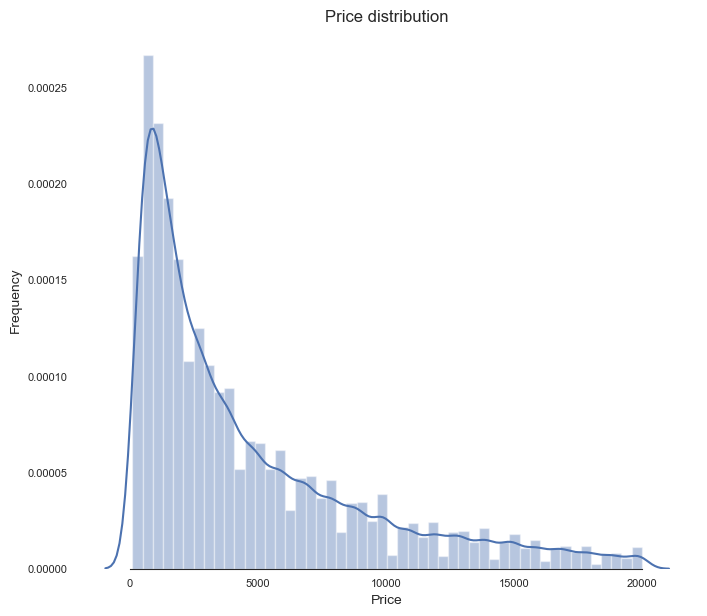

In [21]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution
sns.distplot(data['Price'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Price")
ax.set(title="Price distribution")
sns.despine(trim=True, left=True)
plt.show()

- Deviation from the normal distribution.
- Observe a noticeable asymmetry.
- There is a clear peak.

### Missing values

In [22]:
# missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Repaired,64357,0.188700
VehicleType,32612,0.095621
FuelType,28349,0.083121
Model,17033,0.049942
Gearbox,16314,0.047834
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Kilometer,0,0.000000
Brand,0,0.000000


There are missing values in 4 columns. These are categorical

In [23]:
# Replace the missing values in each of the columns with their mode
data['Model']= data['Model'].fillna('unknown')
data['Repaired'] = data['Repaired'].fillna(data['Repaired'].mode()[0])
data['Gearbox']= data['Gearbox'].fillna(data['Gearbox'].mode()[0])
data['FuelType'] = data['FuelType'].fillna(data['FuelType'].mode()[0])
data['VehicleType'] = data['VehicleType'].fillna(data['VehicleType'].mode()[0])

In [24]:
# check if we have removed all the gaps
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Price,0,0.0
VehicleType,0,0.0
RegistrationYear,0,0.0
Gearbox,0,0.0
Power,0,0.0
Model,0,0.0
Kilometer,0,0.0
FuelType,0,0.0
Brand,0,0.0
Repaired,0,0.0


### Outliars

**Price and power analysis**

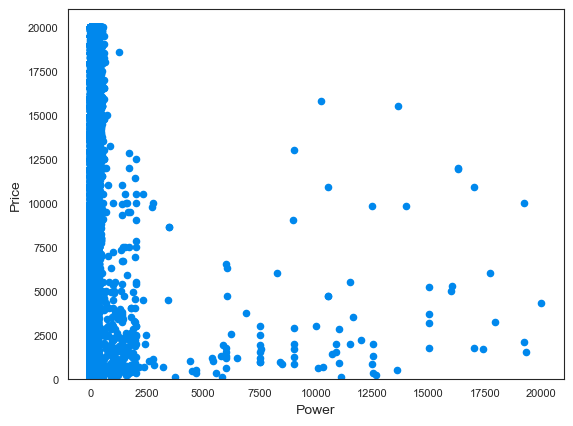

In [25]:
var = 'Power'
data1 = pd.concat([data['Price'], data[var]], axis=1)
data1.plot.scatter(x=var, y='Price', ylim=(0,21000))
plt.show()

In [26]:
data['Power'].describe()

count    341055.000000
mean        111.396197
std         188.373379
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

There are clear outliers here. 

Replace them with the average value.

Define the upper and lower bounds using quantiles.

In [27]:
q1 = data['Power'].quantile(0.99)
q2 = data['Power'].quantile(0.11)
power_mean = data['Power'].mean()
print(q1, q2, power_mean)

300.0 44.0 111.3961970943103


In [28]:
# replace the outliers in the Power column with the average value
data['Power'] = data['Power'].apply(lambda x: power_mean if (x >= q1 or x < q2) else x)

**Analysis of the price and year of registration of the car**

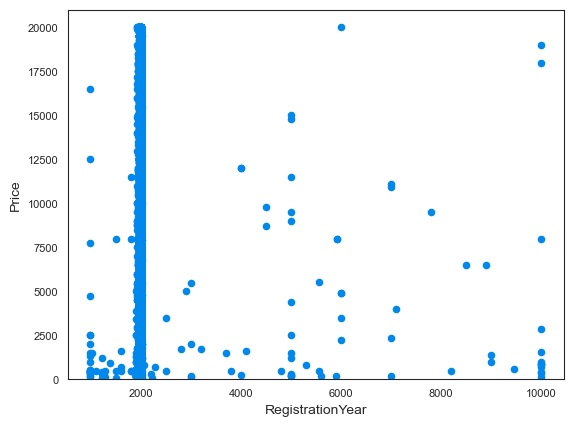

In [29]:
var = 'RegistrationYear'
data1 = pd.concat([data['Price'], data[var]], axis=1)
data1.plot.scatter(x=var, y='Price', ylim=(0,21000))
plt.show()

In [30]:
data['RegistrationYear'].describe()

count    341055.000000
mean       2003.955303
std          69.811742
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

There are invalid values. Replace the outliers with the average value of the year of registration.

In [31]:
q1 = data['RegistrationYear'].quantile(0.99)
q2 = data['RegistrationYear'].quantile(0.005)
year_mean = data['RegistrationYear'].mean()
print(q1,q2, year_mean)

2018.0 1972.0 2003.9553033968127


In [32]:
# replace the outliers with the average value - 2004
data['RegistrationYear'] = data['RegistrationYear'].apply(lambda x: 2004 if x >= 2018 or x <= 1972 else x)

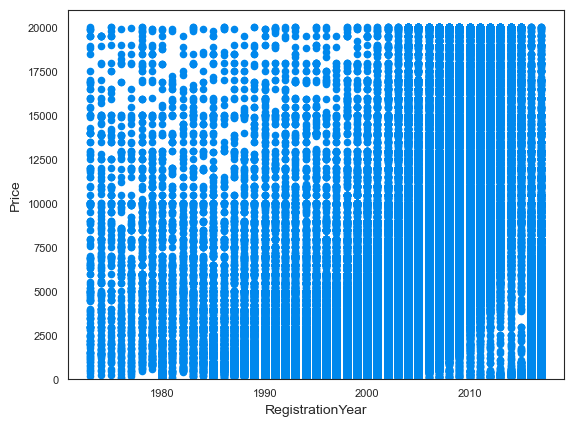

In [33]:
var = 'RegistrationYear'
data1 = pd.concat([data['Price'], data[var]], axis=1)
data1.plot.scatter(x=var, y='Price', ylim=(0,21000))
plt.show()

### Correcting the skewness of distributions

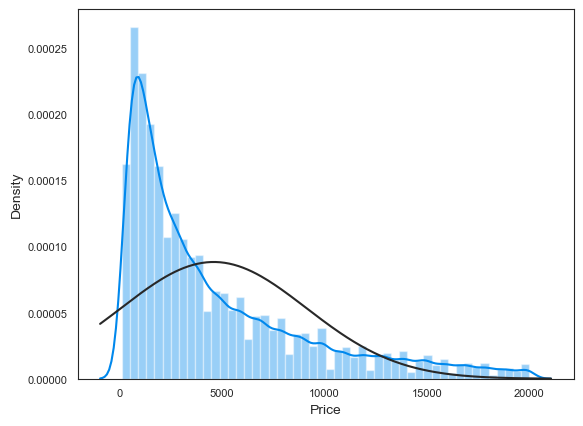

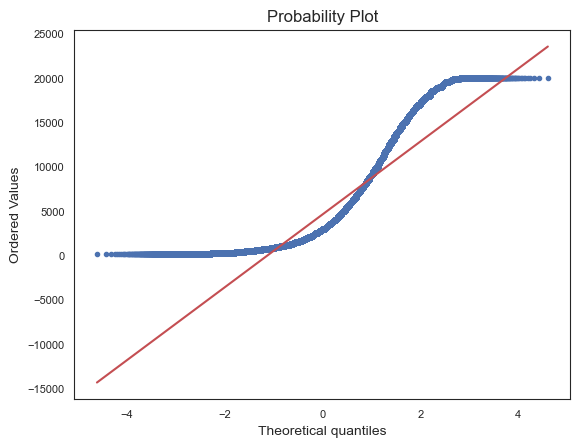

In [34]:
sns.distplot(data['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['Price'], plot=plt)
plt.show()

The price distribution is shifted to the right. Most machine learning models perform poorly on non-normally distributed data. We can apply a log(x) transformation to fix the skew.

In [35]:
data["Price"] = np.log(data["Price"])

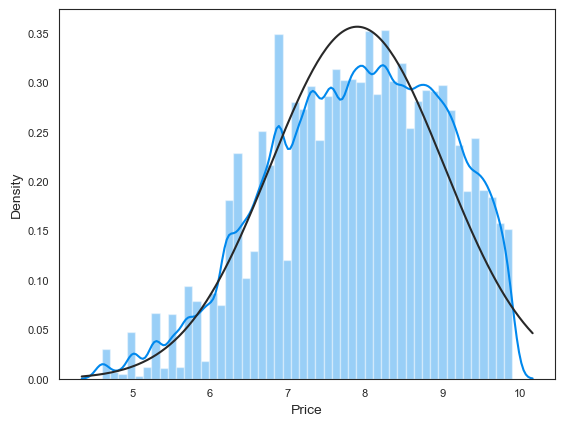

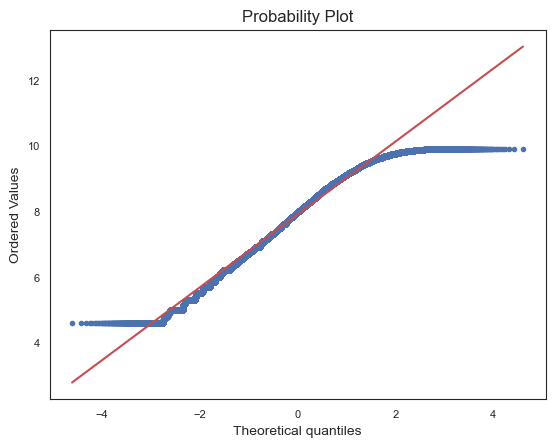

In [36]:
#transformed histogram and normal probability plot
sns.distplot(data["Price"], fit=norm);
fig = plt.figure()
res = stats.probplot(data["Price"], plot=plt)
plt.show()

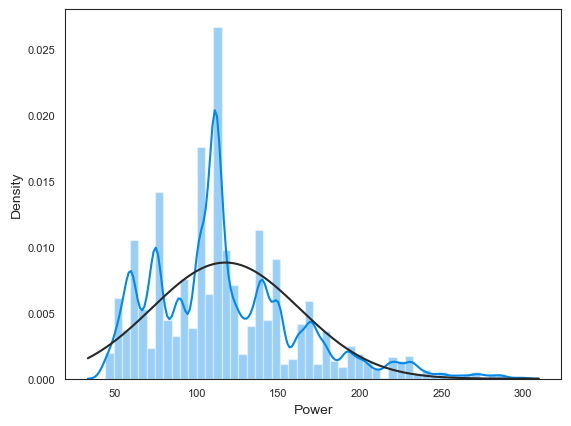

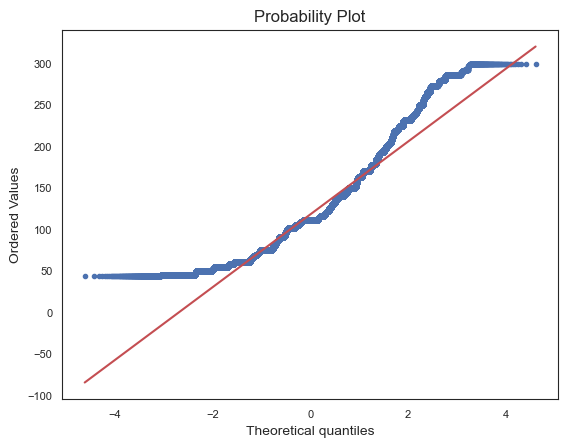

In [37]:
sns.distplot(data['Power'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['Power'], plot=plt)
plt.show()

In [38]:
data["Power"] = np.log(data["Power"])

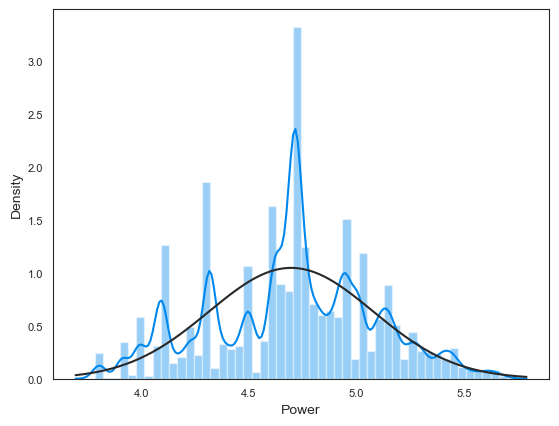

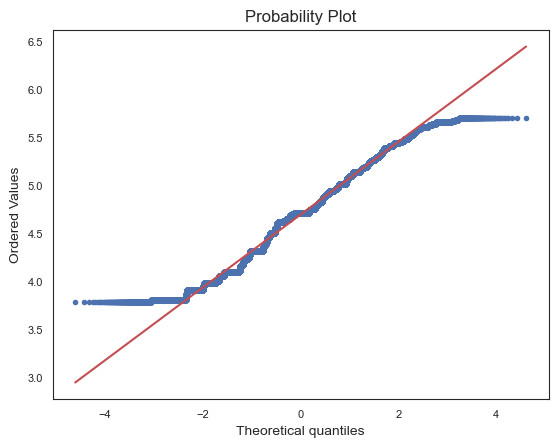

In [39]:
sns.distplot(data['Power'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['Power'], plot=plt)
plt.show()

## Model training

In [40]:
X = data.drop('Price', axis=1)
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [42]:
categorical = ['VehicleType', 'Gearbox', 'Power', 'FuelType', 'Brand', 'Repaired', 'Model']
numerical = ['RegistrationYear', 'Power', 'Kilometer']

In [43]:
enc = OrdinalEncoder()
X_train[categorical] = enc.fit_transform(X_train[categorical])
X_test[categorical] = enc.fit_transform(X_test[categorical])

In [44]:
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.fit_transform(X_test[numerical])

In [45]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [46]:
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf, n_jobs=-1))
    return (rmse)

### Light Gradient Boosting Regressor - hyperparameter tuning

In [47]:
lightgbm = LGBMRegressor(objective='regression', random_state=42)
lgbm_parameters = {'n_estimators': [10, 50, 100],
                   'subsample': [0.5, 0.7, 1.0],
                   'max_depth': [3, 4, 5], 
                   'num_leaves': [3, 6, 9]}

lgbm_grid_search = GridSearchCV(estimator=lightgbm, param_grid=lgbm_parameters, n_jobs=-1, cv=kf, scoring='neg_root_mean_squared_error')

# storing the values
lgbm_grid_result = lgbm_grid_search.fit(X_train, y_train)
# printing the best parameters
print("Accuracy score for LGBMRegressor: %f using %s" % (lgbm_grid_result.best_score_, lgbm_grid_result.best_params_))

Accuracy score for LGBMRegressor: -0.538327 using {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 9, 'subsample': 0.5}


### Random Forest Regressor - hyperparameter tuning

In [48]:
rf = RandomForestRegressor(random_state=42)
rf_parameters = {'n_estimators': [10, 50, 100],
                 'max_depth': [3, 5, 10], 
                 'min_samples_leaf': [3, 5, 7],
                 'min_samples_split': [1, 3]}

rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_parameters, n_jobs=-1, cv=kf, scoring='neg_root_mean_squared_error')

# storing the values
rf_grid_result = rf_grid_search.fit(X_train, y_train)
# printing the best parameters
print("Accuracy score for RandomForestRegressor: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))

Accuracy score for RandomForestRegressor: -0.555161 using {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}


### Cross Validation of Models

In [49]:
# Light Gradient Boosting Regressor 
lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=9,
                         n_estimators=100,
                         subsample=0.5,
                         max_depth=5,
                         random_state=42,
                         n_jobs=-1)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.1,
                       n_estimators=100,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42,
                       n_jobs=-1)

# Ridge Regressor
ridge_alphas = [1e-3, 1e-2, 1e-1, 1, 10]
ridge = RidgeCV(alphas=ridge_alphas, cv=kf)


# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=10,
                           min_samples_split=3,
                           min_samples_leaf=3,
                           random_state=42,
                           n_jobs=-1)

# Elastic Net
elastic = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)



In [50]:
%%time
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.5383 (0.0050)
Wall time: 2.57 s


In [51]:
%%time

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgboost'] = (score.mean(), score.std())

xgboost: 0.5290 (0.0048)
Wall time: 16.3 s


In [52]:
%%time

score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.5552 (0.0051)
Wall time: 57.5 s


In [53]:
%%time

score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.7632 (0.0051)
Wall time: 5.48 s


In [54]:
%%time

score = cv_rmse(elastic)
print("elastic: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['elastic'] = (score.mean(), score.std())

elastic: 0.8108 (0.0047)
Wall time: 678 ms


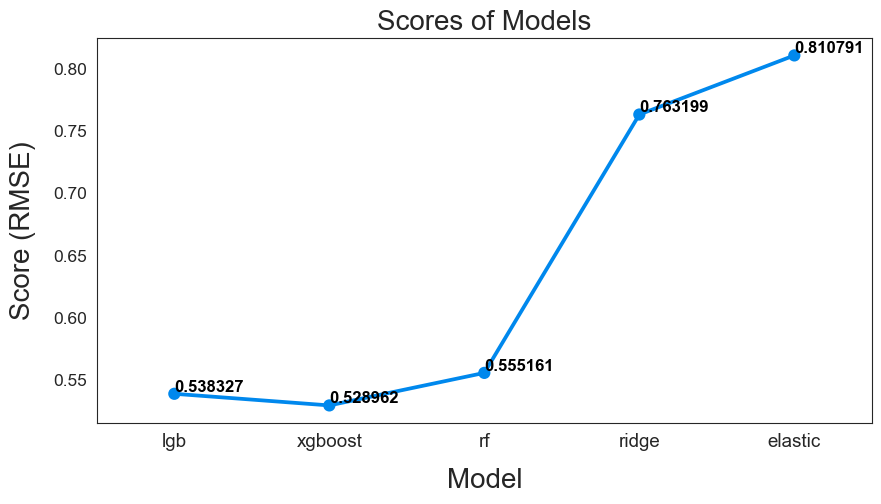

In [74]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(10, 5))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

### Training

In [56]:
%%time
lgb_model_full_data = lightgbm.fit(X_train, y_train)


Wall time: 288 ms


In [57]:
%%time
lgb_predict = lgb_model_full_data.predict(X_train)


Wall time: 177 ms


In [58]:
%%time
xgboost_model_full_data = xgboost.fit(X_train, y_train)

[14:17:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 2.36 s


In [59]:
%%time
xgboost_predict = xgboost_model_full_data.predict(X_train)


Wall time: 63.8 ms


In [60]:
%%time
ridge_model_full_data = ridge.fit(X_train, y_train)

Wall time: 1.36 s


In [61]:
%%time
ridge_predict = ridge_model_full_data.predict(X_train)


Wall time: 4.99 ms


In [62]:
%%time
rf_model_full_data = rf.fit(X_train, y_train)
 

Wall time: 5.71 s


In [63]:
%%time
rf_predict = rf_model_full_data.predict(X_train)


Wall time: 344 ms


In [64]:
%%time
elastic_model_full_data = elastic.fit(X_train, y_train)

Wall time: 50 ms


In [65]:
%%time
elastic_predict = elastic_model_full_data.predict(X_train)


Wall time: 3.99 ms


### Comparison

In [66]:
index = ['Light Gradient Boosting Regressor', 
         'XGBoost Regressor', 
         'Ridge Regressor',
         'Random Forest Regressor', 
         'Elastic NET']
df = {'RMSE на CV, euro':[scores.get('lgb')[0],
                            scores.get('xgboost')[0],
                            scores.get('ridge')[0], 
                            scores.get('rf')[0],
                            scores.get('elastic')[0]],
        'Time of training, s':[110,
                               58.7,
                               10,
                               29.6,
                               0.086],
        'Time of testing, s':[1.48,
                              0.485,
                              0.005,
                              2.1,
                              0.094]}

scores_data = pd.DataFrame(data=df, index=index)

scores_data

,"RMSE на CV, euro","Time of training, s","Time of testing, s"
Light Gradient Boosting Regressor,0.538327,110.000,1.480
XGBoost Regressor,0.528962,58.700,0.485
Ridge Regressor,0.763199,10.000,0.005
Random Forest Regressor,0.555161,29.600,2.100
Elastic NET,0.810791,0.086,0.094


**Resume**

- The most accurate model is `XGBoost Regressor`, the least accurate is `Elastic NET`
- The fastest model in training is `Elastic NET`, the slowest is `Light Gradient Boosting Regressor`
- The fastest model in prediction is `Ridge Regressor`, the slowest one is `Random Forest Regressor`


## Best model testing

The most promising model in terms of important criteria: (prediction quality; model training time; model prediction time) turned out to be the **XGBoost Regressor** model. This model is quite fast in training and prediction and shows high accuracy.

In [71]:
xgb_test_predict = xgboost_model_full_data.predict(X_test)
rms = np.sqrt(mean_squared_error(y_test, xgb_test_predict))
print('RMSE', round(rms, 3))

RMSE 0.537


## Conclusions

The following was done:

- Data loaded and pre-processed.
- Trained 5 different models on cross-validation
- Comparison of models is executed.
- The best model was selected based on the results of the RMSE metric and training time.

The best model in terms of quality, learning rate and prediction rate can be considered XGBoost Regressor.

Elastic NET and Ridge proved to be very weak in this task.

LGBMRegressor also showed high accuracy, but training and prediction based on this model is quite long compared to the rest.
